In [2]:
import time
import numpy as np
import argparse
import scipy.stats as stat
import os
from noisyopt import minimizeCompass
from scipy.optimize import minimize
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import operator
import pickle
from operator import itemgetter
import ipywidgets as widgets
#from IPython.display import display
#from IPython.display import clear_output
import csv
import h5py
os.chdir("/global/cscratch1/sd/zladd/axonstandardized/playground/")


# parser = argparse.ArgumentParser(description='Analyze P Parllel')
# parser.add_argument('--model', type=str, required=True, help='specifies model for AnalyzeP')
# parser.add_argument('--peeling', type=str, required=True, help='specifies peeling for AnalyzeP')
# parser.add_argument('--CURRENTDATE', type=str, required=True, help='specifies date')
# parser.add_argument('--custom', type=str, required=False, help='specifies custom postfix')

#args = parser.parse_args()
model = "bbp" #args.model
peeling = "calcium" #args.peeling
currentdate = "02_14_2021" #args.CURRENTDATE
custom = "full"

# Data Files
if custom is not None:
    wrkDir = 'runs/' + model + '_' + peeling + '_' + currentdate + custom
else:
    wrkDir = 'runs/' + model + '_' + peeling + '_' + currentdate
opt_path = wrkDir + '/genetic_alg/optimization_results/opt_result_single_stim_' + model + '_' + peeling + '_full.hdf5'
save_path = wrkDir + '/genetic_alg/objectives'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
params_path = 'params/params_' + model + '_' + peeling + '.hdf5'
scores_path =  wrkDir + '/scores/'
params_file = h5py.File(params_path, 'r')
opt_file = h5py.File(opt_path, 'r')
# Constants
coarseStepSize = 0.1
fineStepSize = 0.01
obj_comb_vec = [1, 0]

# Value in range [0, 1] reflecting percent of data to use for training.
# 1 - proportionToTrain will be used for validation.
proportionToTrain = 0.7
# Integer in range [1, len(stim_names)].
# The number of top stims to use for multi-stim optimization.
# If k = 1, then use the top stim only.
k = 1
# random seed to use for train/validation on optimization
seed = 500
# Weights for optimization.
param_select_vec = None
score_function_list = [e.decode('ascii') for e in opt_file['ordered_score_function_list'][:]]
# Dump these parameters to a pickle file so that
# they can be used by the utility script file
# when it is run in the next section.
print(os.getcwd())
with open("analyze_p_bbp_full/params.pkl", 'wb') as f:
    pickle.dump([
        scores_path,
        params_path,
        score_function_list,
        coarseStepSize,
        fineStepSize
    ], f)



# Load analysis-specific utilities from script file.
#TODO what is this?
#%run ./new_AnalyzeP.py
#placeholder as sleep, need to just do this on one node and comm info out to other nodes?
# TODO fix monkeypatch
time.sleep(5)
print("NAP OVER")
from new_AnalyzeP import *

ordered_stim_list, ordered_score_function_list, pin_score_dict = main()


# Fixes a shuffled order.
# Applies the same shuffled order on fed data.
# After shuffling, you can use say the first 70% for training and the last 30% for validation.
def fix_shuffled_subset_list(length):
    shuffle_pattern = np.arange(length)
    np.random.shuffle(shuffle_pattern)
    def subset_list(subset=None):
        if subset == 'train':
            return sorted(shuffle_pattern[:int(length*proportionToTrain)])
        elif subset == 'test':
            return sorted(shuffle_pattern[int(length*proportionToTrain):])
        else:
            return shuffle_pattern
    return subset_list

# Plots the sensitivity matrix as a heat map.
# Vertical axis is the parameter index and
# Horizontal axis is the numbering of each param set.
def plot_heat_map(mat, stim='', sf=''):
    # Heat Map for all elementary effects.
    #['gna_dend','gna_node','gna_soma','gkv_axon','gkv_soma','gca_dend','gkm_dend','gkca_dend','gca_soma','gkm_soma','gkca_soma','depth_cad']
    data = mat.T
    plt.imshow(data, cmap='RdBu_r', aspect='auto')
    ax = plt.gca()
    ax.invert_yaxis()
#    if stim is 'Weighted matrix':
    #plt.title('Weighted matrix', fontsize=15)
#     else:
    plt.title('Elementary effect for ' + stim + ' input\n and ' + sf + ' score function', fontsize=15)
    plt.ylabel('Parameter set', fontsize=18)
    plt.xlabel('Parameter name', fontsize=18)
    plt.colorbar()
    #plt.savefig('./heat_map_potassium.eps', format='eps', dpi=1000)
    plt.show()

def compute_lin_comb_mat(stim_name, weight_vector, sensitivity_dict):
    return sum([sensitivity_dict[stim_name][i]*weight_vector[i] for i in range(len(weight_vector))])

def plot_lin_comb_as_heat_map(stim_name, weight_vector, sensitivity_dict):
    if isinstance(stim_name, str):
        # Single stim.
        lin_comb_mat = compute_lin_comb_mat(stim_name, weight_vector, sensitivity_dict)
        print('Weighted Mat: ')
        plot_heat_map(lin_comb_mat, stim_name)
    else:
        # Multi-stim.
        lin_comb_mat = sum([
            compute_lin_comb_mat(stim_name[i], weight_vector[i*len(score_function_list):(i+1)*len(score_function_list)], sensitivity_dict) for i in range(len(stim_name))])

        plot_heat_map(lin_comb_mat, '\n & '.join(stim_name))

# @arg stim_name can either be the name of a single stim, or it can be a list of multiple stim names.
# In the latter case, optimize will be run in multi-stim mode.
def trainAndValidateScoreOptimization(stim_name, showHeatMap=False, seed=500, verbosity=True, saveToFile=False):
    np.random.seed(seed)

    if verbosity:
        plt.figure(figsize=(15,7))
        plt.title('Optimal weighted scores for ' + '\n & '.join(stim_name))
        plt.xlabel('Parameter Set Rank')
        plt.ylabel('Optimization value')

    if isinstance(stim_name, str):
        N = len(pin_score_dict[stim_name][0])
    else:
        NForEachStim = [len(pin_score_dict[single_stim][0]) for single_stim in stim_name]
        # Each of the stims in the list must be of the same length!
        assert all(N == NForEachStim[0] for N in NForEachStim), 'Each stim is not of the same length.'
        N = NForEachStim[0]

    # Create a pattern and use the pattern to select indices of training and testing data.
    shuffle_pattern = fix_shuffled_subset_list(N)
    training = shuffle_pattern('train')
    testing = shuffle_pattern('test')

    # Optimize on the training set.
    train_result, train_score_mat, _ = optimize(stim_name, training)
    train_result = train_result.x
    if verbosity:
        plt.scatter(training, train_result @ train_score_mat, label='Training Data')
        plt.plot(training, np.poly1d(np.polyfit(training, train_result @ train_score_mat, 1))(training))

    # Optimize on the entire set to establish a ground truth.
    test_result, test_score_mat, _ = optimize(stim_name)
    # Optimize on the testing set to establish a ground truth.
    #test_result, test_score_mat, _ = optimize(stim_name, testing, obj_comb_vec = obj_comb_vec)
    test_result = test_result.x
    if verbosity:
        plt.scatter(np.arange(N), train_result @ test_score_mat, label='Testing Data')
        plt.plot(np.arange(N), np.poly1d(np.polyfit(np.arange(N), train_result @ test_score_mat, 1))(np.arange(N)))
        #plt.scatter(np.arange(N), test_result @ test_score_mat, label='Ground Truth Test')
        #plt.plot(np.arange(N), np.poly1d(np.polyfit(np.arange(N), test_result @ test_score_mat, 1))(np.arange(N)))

        # Replot training and testing data on top of ground truth data.
        plt.scatter(np.arange(N), train_result @ test_score_mat, color='C1')
        plt.scatter(training, train_result @ train_score_mat, color='C0')

        # Print stims used, which were the top k stims.
        if len(stim_name) == 1:
            print('Single stim optimization:', stim_name[0])
        else:
            print('Top', min(k, len(stim_name)), 'stims:', stim_name)
        print()

#         # Print weights
#         print('Each row belongs to a single stim.')
#         print('Training Weights:\n', train_result.reshape([min(k, len(stim_name)), len(score_function_list)]))
#         print('Ground Truth Weights:\n', test_result.reshape([min(k, len(stim_name)), len(score_function_list)]))
#         print()

#         # Print spearman scores for the three sets of sampled data.
#         print('Training Spearman:', round(stat.spearmanr(np.asarray(training), train_result @ train_score_mat)[0], 5))
#         print('Testing Spearman:', round(stat.spearmanr(np.arange(N), train_result @ test_score_mat)[0], 5))
#         print('Ground Truth Spearman:', round(stat.spearmanr(np.arange(N), test_result @ test_score_mat)[0], 5))

#         plt.legend()
#         #plt.savefig('./trainset_and_groundtruth_potassium.eps', format='eps', dpi=1000)
#         plt.show()

#     if showHeatMap:
#         plot_lin_comb_as_heat_map(stim_name, train_result, sensitivity_dict)

#     if saveToFile:
#         # Save the ground truth weights reshaped into a single vector.
#         #np.savetxt("optimal_weight_list.csv", test_result.reshape([1, test_result.shape[0]]), delimiter=",")

#         # Save the stim names used in this optimization.
#         with open("optimal_stim_list.csv", 'w') as f:
#             wr = csv.writer(f, quoting=csv.QUOTE_ALL, delimiter=" ")
#             wr.writerow(stim_name)

    # Return weights
    stims_optimal_order = [np.string_(e) for e in stim_name]
    return np.array(test_result.reshape([1, test_result.shape[0]])), np.array(stims_optimal_order)



/global/cscratch1/sd/zladd/axonstandardized/playground
NAP OVER
params.pkl successfully loaded.
params.pkl successfully loaded.


Top 2 stims: ['chirp_f_0_to_0.3_a_0.05_to_0.2_m_-0.1', 'chirp_f_0_to_0.1_a_0.05_to_0.1_m_-0.1']

Each row belongs to a single stim.
Training Weights:
 [[5.48813504e+01 7.15189366e+01 6.02763376e+01 5.44883183e+01
  4.23654799e+01 6.45894113e+01 4.37587211e+01 8.91773001e+01
  9.63662761e+01 3.83441519e+01 7.91725038e+01 5.28894920e+01
  5.68044561e+01 9.25596638e+01 7.10360582e+00 8.71292997e+00
  2.02183974e+00 8.32619846e+01 7.78156751e+01 8.70012148e+01
  9.78618342e+01 7.99158564e+01 4.61479362e+01 7.80529176e+01
  1.18274426e+01 6.39921021e+01 1.43353287e+01 9.44668917e+01
  5.21848322e+01 4.14661940e+01 2.64555612e+01 7.74233689e+01
  4.56150332e+01 5.68433949e+01 1.87898004e+00 6.17635497e+01
  6.12095723e+01 6.16933997e+01 9.43748079e+01 6.81820299e+01
  3.59507901e+01 4.37031954e+01 6.97631196e+01 6.02254716e+00
  6.66766715e+01 0.00000000e+00 2.10382561e+01 1.28926298e+01
  3.15428351e+01 3.63710771e+01 5.70196770e+01 4.38601513e+01
  9.88373838e+01 1.02044811e+01 9.99755859e

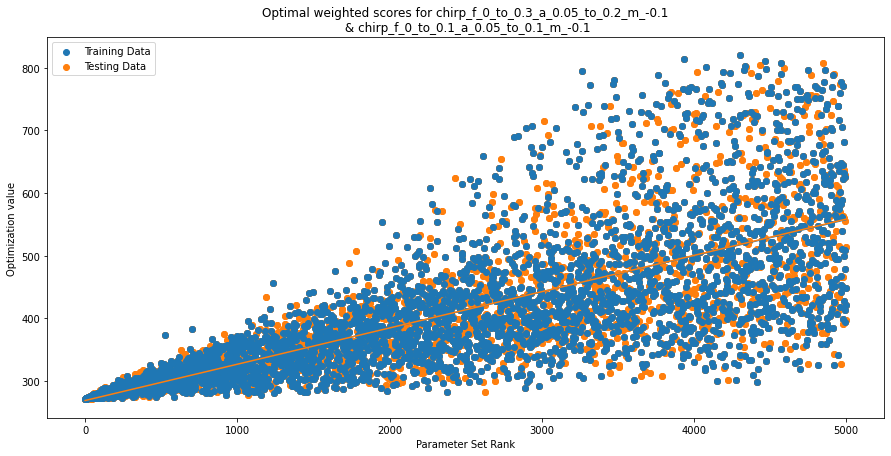

(1, 192) (2,)
1058.1495792865753  TOOK


ZeroDivisionError: division by zero

In [27]:
stimsInOrder = [e.decode('ascii') for e in opt_file['stims_optimal_order'][:]]
k=2
start_time = time.time()
weight_list, stim_list = trainAndValidateScoreOptimization(stimsInOrder[:k], True, seed=seed, saveToFile=True)
print(weight_list.shape, stim_list.shape )
end_time = time.time()
print(end_time - start_time, " TOOK")
print(1/0)
opt_result_hdf5 = h5py.File(save_path +'/multi_stim_without_sensitivity_' + model \
+ '_' + peeling +'_'+ currentdate + '_stims.hdf5', 'w')
ordered_score_function_list_as_binary = np.array([np.string_(e) for e in score_function_list])
opt_result_hdf5.create_dataset('ordered_score_function_list', data=ordered_score_function_list_as_binary)
opt_result_hdf5.create_dataset('opt_stim_name_list', data=stim_list)
opt_result_hdf5.create_dataset('opt_weight_list', data=weight_list[0])
opt_result_hdf5.close()


In [15]:

onewait.shape, onestim.shape

((1, 96), (1,))

In [4]:
import multiprocessing
from multiprocessing import Pool

multiprocessing.cpu_count()

64

In [8]:
k=20
stimsInOrder = [e.decode('ascii') for e in opt_file['stims_optimal_order'][:]]
start_time = time.time()
with Pool(64) as p: 
    res = p.map(trainAndValidateScoreOptimization, stimsInOrder[:k])
end_time = time.time()
weight_list, stim_list = res_transform(res) 
print(end_time - start_time, "TOOK")
print(1/0)
opt_result_hdf5 = h5py.File(save_path +'/multi_stim_without_sensitivity_' + model \
+ '_' + peeling +'_'+ currentdate + '_stims.hdf5', 'w')
ordered_score_function_list_as_binary = np.array([np.string_(e) for e in score_function_list])
opt_result_hdf5.create_dataset('ordered_score_function_list', data=ordered_score_function_list_as_binary)
opt_result_hdf5.create_dataset('opt_stim_name_list', data=stim_list)
opt_result_hdf5.create_dataset('opt_weight_list', data=weight_list[0])
opt_result_hdf5.close()


Top 20 stims: chirp_f_0.16_to_0_a_6_to_6

Top 17 stims: sin_f_0.9_a_6_m_0

Top 8 stims: he_1_1_8

Top 10 stims: he_3_14_19

Top 20 stims: chirp_f_0_to_0.2_a_0.05_to_0.2_m_-0.1

Top 20 stims: chirp_f_0.24_to_0_a_6_to_6

Top 20 stims: chirp_f_0_to_0.05_a_0.05_to_0.1_m_-0.1

Top 15 stims: sin_f_1_a_3_m_0

Top 20 stims: chirp_f_0_to_0.3_a_0.05_to_0.2_m_-0.1

Top 20 stims: chirp_f_0_to_0.1_a_0.05_to_0.1_m_-0.1

Top 12 stims: negramp_-0.3

Top 20 stims: chirp_f_0.16_to_0_a_3_to_3

Top 20 stims: chirp_f_0_to_0.2_a_0.05_to_0.1_m_-0.1

Top 9 stims: he_3_14_8

Top 10 stims: he_3_19_20

Top 17 stims: sin_f_0.3_a_6_m_0

Top 20 stims: chirp_f_0.28_to_0_a_9_to_3

Top 20 stims: chirp_f_0.26_to_0_a_6_to_6

Top 8 stims: he_1_6_3

Top 20 stims: chirp_f_0.26_to_0_a_9_to_3

2855.352974653244 TOOK


ZeroDivisionError: division by zero

In [35]:

twowait.shape, twostim.shape, onewait.shape, onestim.shape, 

((1, 192), (2,), (1, 96), (1,))

In [7]:
def res_transform(res):
    stim_list2 = []
    weight_list2 = np.array([])
    for weights,stim_name in res:
        stim_list2.append(b''.join(stim_name ))
        if len(weight_list2) < 1:
            weight_list2 = weights
        else:
            weight_list2 = np.append(weight_list2, weights, axis=1)
    return weight_list2, stim_list2

In [6]:
stim_list2 = []
weight_list2 = np.array([])
res = [weight_list, stim_list]
for weights,stim_name in res:
    stim_list2.append(b''.join(stim_name ))
    if len(weight_list2) < 1:
        weight_list2 = weights
    else:
        weight_list2 = np.append(weight_list2, weights, axis=1)
        


NameError: name 'weight_list' is not defined

(45.08144012174866, 44.045484480519484)

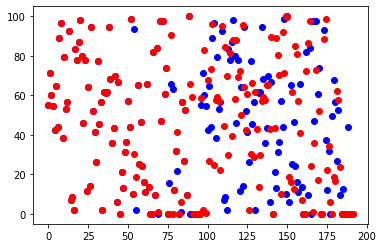

In [77]:
twowait.shape, weight_list2.shape
plt.scatter(np.arange(192),weight_list2, color="blue")
plt.scatter(np.arange(192),twowait, color="red")
np.mean(twowait), np.mean(weight_list2)

In [2]:
np.array(stim_list).shape

NameError: name 'np' is not defined

In [1]:
np.mean(stim_list)

NameError: name 'np' is not defined